In [1]:
# vacation dates (3/3/2018 - 3/10/2018)
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import desc

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
['m', 's']

# Map Europe class
M = Base.classes.measurement

# Map North American class
S = Base.classes.station

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)

('2017-08-23',)
2016-08-23


In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
stmt = session.query(Measurement).\
       order_by(Measurement.date.asc()).statement

df = pd.read_sql_query(stmt, session.bind)

df2 = df[(df['date'] >= '2016-08-23')].fillna(0).reset_index().rename(index=str, columns={"prcp": "precipitation"})

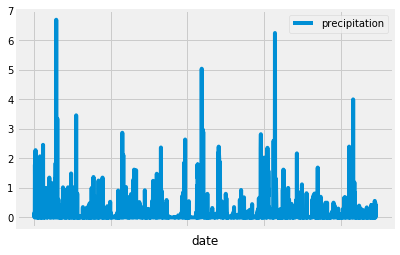

In [13]:
df2.plot(x='date', y='precipitation')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2['precipitation'].describe()

count    2230.000000
mean        0.160664
std         0.442067
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000
Name: precipitation, dtype: float64

In [15]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count()
print(stations)

9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
xlist = []

min_ = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").all()
max_ = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").all()
busy = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").all()

xlist.append('Mintemp: '+ str(np.min(min_)))
xlist.append('Maxtemp: '+ str(np.max(max_)))
xlist.append('Avg Temp: '+ str(np.mean(busy)))

print(xlist)

['Mintemp: 54.0', 'Maxtemp: 85.0', 'Avg Temp: 71.66378066378067']


In [132]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df3 = df[(df['date'] >= '2016-08-23') & (df['station']=='USC00519281')].fillna(0).reset_index().rename(index=str, columns={"prcp": "precipitation"})
df3.head()

,index,id,station,date,precipitation,tobs
0,17325,14608,USC00519281,2016-08-23,1.79,77.0
1,17332,14609,USC00519281,2016-08-24,2.15,77.0
2,17339,14610,USC00519281,2016-08-25,0.06,80.0
3,17346,14611,USC00519281,2016-08-26,0.01,80.0
4,17351,14612,USC00519281,2016-08-27,0.12,75.0


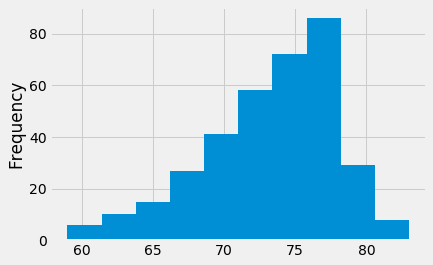

In [133]:
 df3['tobs'].plot.hist(alpha=1)

In [134]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-01-27', '2012-03-05'))

[(56.0, 69.30819672131148, 78.0)]


In [135]:
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

values = calc_temps('2016-08-23', '2017-08-23')

columns = ['min', 'avg', 'max']
dataframe = pd.DataFrame(values, columns=columns)
dataframe.head()


,min,avg,max
0,58.0,74.590583,87.0


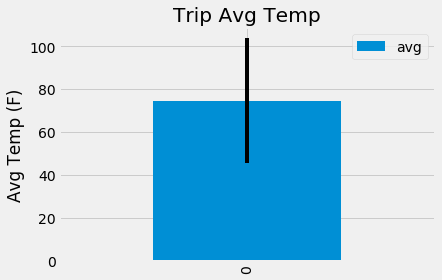

In [136]:
#get values from dataframe
final_value = (dataframe.iloc[0, 2] - dataframe.iloc[0, 0])

#plot
dataframe.plot.bar(y ='avg', yerr = [final_value])

# Add title and axis names
plt.title('Trip Avg Temp')
plt.ylabel('Avg Temp (F)')
 
# Show graphic
plt.show()


In [137]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, S.name, S.latitude, S.longitude, S.elevation, func.sum(Measurement.prcp)).\
filter(Measurement.date >= '2017-03-03').filter(Measurement.date <= '2017-03-10').\
join(S, S.station == M.station).\
group_by(Measurement.station).\
order_by(desc(func.sum(Measurement.prcp))).all()

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.08),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.39),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.92),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.82),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.63),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.25),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.14)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


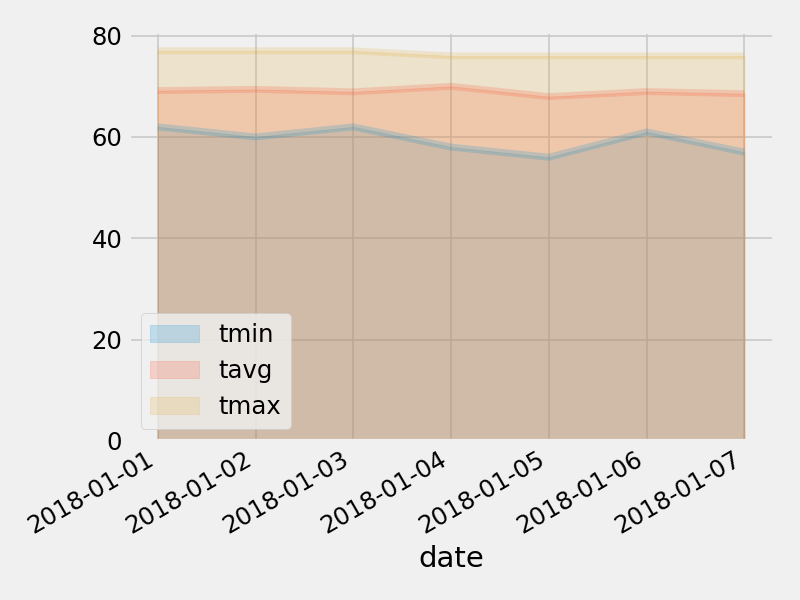

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
